# 1. Getting VizDoom Up and Running

In [ ]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [ ]:
!pip install vizdoom matplotlib gym

In [ ]:
!pip install stable-baselines3[extra]

In [1]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [9]:
# Setup game
game = DoomGame()
game.load_config('Github_VizDoom/VizDoom/scenarios/deadly_corridor.cfg')
game.init()

In [10]:
# This is the set of actions we can take in the environment
actions = np.identity(7, dtype=np.uint8)

In [11]:
state = game.get_state()

In [12]:
state.game_variables

array([100.,   0.,   0.,  -1.])

In [14]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: -0.78125
reward: -2.458099365234375
reward: -1.6581268310546875
reward: -10.89544677734375
reward: 0.0
reward: -0.201385498046875
reward: 6.8990478515625
reward: 15.175491333007812
reward: 6.9597015380859375
reward: 2.7304534912109375
reward: 2.71295166015625
reward: 0.1704254150390625
reward: -0.7565460205078125
reward: 6.54901123046875
reward: 5.3015594482421875
reward: 4.534088134765625
reward: 2.2701873779296875
reward: -0.625030517578125
reward: 2.090423583984375
reward: 4.6722412109375
reward: 4.4420318603515625
reward: 2.99609375
reward: -2.4080963134765625
reward: -8.37908935546875
reward: -2.4318389892578125
reward: -3.8639373779296875
reward: -3.9944305419921875
reward: -6.117279052734375
reward: -2.1261444091796875
reward: 0.5397796630859375
reward: 4.7927398681640625
reward: 0.4111480712890625
reward: -101.2255859375
Result: -74.67491149902344
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: -15.975631713867188
reward: 0.0
reward: 0.0
reward: 4.96

In [15]:
game.close()

# 2. Converting it to a Gym Environment

In [2]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [3]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False, config="Github_VizDoom/VizDoom/scenarios/deadly_corridor_s1.cfg"): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(7)
        
        #Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self. hitcount = 0
        self.ammo = 52 ##DO NOT CHANGE THIS VALUE
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) 
        
        reward = 0
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            #Reward Shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            #Calculate reward deltas, keep previous data to learn not to waste ammo or try to take damage
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            
            hitcount_delta = -hitcount + self.hitcount
            self.hitcount = hitcount
            
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200 + ammo_delta*5
            
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [10]:
env = VizDoomGym(render=True)

In [11]:
state = env.reset()

# 3. View Game State

In [4]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [14]:
env_checker.check_env(env)

# 3. View State

In [15]:
from matplotlib import pyplot as plt

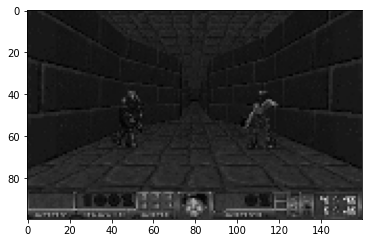

In [16]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [17]:
env.close()

# 4. Setup Callback

In [4]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [6]:
CHECKPOINT_DIR = "./train/train_deadly_corridor/DQN"
LOG_DIR = "./logs/log_deadly_corridor"

In [7]:
callback = TrainAndLoggingCallback(check_freq=50000, save_path=CHECKPOINT_DIR)

# 5. Train Model Using Curriculum

In [4]:
# import ppo for training
from stable_baselines3 import PPO, DQN

In [9]:
# Non rendered environment
env = VizDoomGym(config="Github_VizDoom/VizDoom/scenarios/deadly_corridor_s1.cfg")

In [11]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9, ent_coef=0.01)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [10]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, batch_size=64, buffer_size=40000, learning_starts=2000, gamma=.95)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [11]:
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_deadly_corridor\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 145      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 272      |
|    time_elapsed     | 2        |
|    total_timesteps  | 580      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | -74      |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 372      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1775     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.942    |
| time/    

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | 194      |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 72       |
|    fps              | 76       |
|    time_elapsed     | 110      |
|    total_timesteps  | 8429     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.6     |
|    n_updates        | 1607     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | 197      |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 73       |
|    time_elapsed     | 118      |
|    total_timesteps  | 8687     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 27.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.1     |
|    ep_rew_mean      | 357      |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 49       |
|    time_elapsed     | 264      |
|    total_timesteps  | 13211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.4     |
|    n_updates        | 2802     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82       |
|    ep_rew_mean      | 365      |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 140      |
|    fps              | 49       |
|    time_elapsed     | 274      |
|    total_timesteps  | 13476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 29.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 70.3     |
|    ep_rew_mean      | 551      |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 42       |
|    time_elapsed     | 414      |
|    total_timesteps  | 17496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.93     |
|    n_updates        | 3873     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 70       |
|    ep_rew_mean      | 565      |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 41       |
|    time_elapsed     | 424      |
|    total_timesteps  | 17773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 29.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 62       |
|    ep_rew_mean      | 629      |
|    exploration_rate | 0.493    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 41       |
|    time_elapsed     | 517      |
|    total_timesteps  | 21338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.2     |
|    n_updates        | 4834     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 61.8     |
|    ep_rew_mean      | 630      |
|    exploration_rate | 0.489    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 41       |
|    time_elapsed     | 521      |
|    total_timesteps  | 21533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.1     |
|    ep_rew_mean      | 628      |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 42       |
|    time_elapsed     | 571      |
|    total_timesteps  | 24453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 35.7     |
|    n_updates        | 5613     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51.9     |
|    ep_rew_mean      | 639      |
|    exploration_rate | 0.415    |
| time/               |          |
|    episodes         | 332      |
|    fps              | 42       |
|    time_elapsed     | 573      |
|    total_timesteps  | 24634    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 688      |
|    exploration_rate | 0.347    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 43       |
|    time_elapsed     | 627      |
|    total_timesteps  | 27497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 33.3     |
|    n_updates        | 6374     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 688      |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 43       |
|    time_elapsed     | 631      |
|    total_timesteps  | 27665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 721      |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 43       |
|    time_elapsed     | 691      |
|    total_timesteps  | 30332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 25.7     |
|    n_updates        | 7082     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | 716      |
|    exploration_rate | 0.275    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 43       |
|    time_elapsed     | 695      |
|    total_timesteps  | 30508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 27.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 768      |
|    exploration_rate | 0.213    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 43       |
|    time_elapsed     | 753      |
|    total_timesteps  | 33116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.6     |
|    n_updates        | 7778     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 770      |
|    exploration_rate | 0.21     |
| time/               |          |
|    episodes         | 524      |
|    fps              | 43       |
|    time_elapsed     | 757      |
|    total_timesteps  | 33268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 24       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 912      |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 584      |
|    fps              | 43       |
|    time_elapsed     | 817      |
|    total_timesteps  | 35877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.2     |
|    n_updates        | 8469     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 926      |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 588      |
|    fps              | 43       |
|    time_elapsed     | 821      |
|    total_timesteps  | 36065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.0814   |
| time/               |          |
|    episodes         | 648      |
|    fps              | 43       |
|    time_elapsed     | 886      |
|    total_timesteps  | 38679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.1     |
|    n_updates        | 9169     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.0779   |
| time/               |          |
|    episodes         | 652      |
|    fps              | 43       |
|    time_elapsed     | 890      |
|    total_timesteps  | 38827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.2     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 43       |
|    time_elapsed     | 953      |
|    total_timesteps  | 41377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.5     |
|    n_updates        | 9844     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42       |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 43       |
|    time_elapsed     | 958      |
|    total_timesteps  | 41545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.24e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 43       |
|    time_elapsed     | 1023     |
|    total_timesteps  | 44091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.3     |
|    n_updates        | 10522    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 780      |
|    fps              | 43       |
|    time_elapsed     | 1028     |
|    total_timesteps  | 44259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.28e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 42       |
|    time_elapsed     | 1098     |
|    total_timesteps  | 46822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56       |
|    n_updates        | 11205    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.3e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 844      |
|    fps              | 42       |
|    time_elapsed     | 1103     |
|    total_timesteps  | 46988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 41       |
|    time_elapsed     | 1183     |
|    total_timesteps  | 49566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 33.5     |
|    n_updates        | 11891    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 908      |
|    fps              | 41       |
|    time_elapsed     | 1188     |
|    total_timesteps  | 49739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 36.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 1.26e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 41       |
|    time_elapsed     | 1272     |
|    total_timesteps  | 52333    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28       |
|    n_updates        | 12583    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 1.25e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 972      |
|    fps              | 41       |
|    time_elapsed     | 1278     |
|    total_timesteps  | 52501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 27.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 1.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 40       |
|    time_elapsed     | 1368     |
|    total_timesteps  | 55074    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.6     |
|    n_updates        | 13268    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 1.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 40       |
|    time_elapsed     | 1375     |
|    total_timesteps  | 55246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.22e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 39       |
|    time_elapsed     | 1459     |
|    total_timesteps  | 57807    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.2     |
|    n_updates        | 13951    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.21e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 39       |
|    time_elapsed     | 1464     |
|    total_timesteps  | 57976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 39       |
|    time_elapsed     | 1547     |
|    total_timesteps  | 60533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 26.7     |
|    n_updates        | 14633    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 39       |
|    time_elapsed     | 1550     |
|    total_timesteps  | 60689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 38       |
|    time_elapsed     | 1636     |
|    total_timesteps  | 63297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.7     |
|    n_updates        | 15324    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 1.24e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 38       |
|    time_elapsed     | 1640     |
|    total_timesteps  | 63474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.9     |
|    ep_rew_mean      | 1.29e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 38       |
|    time_elapsed     | 1722     |
|    total_timesteps  | 66028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.7     |
|    n_updates        | 16006    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43       |
|    ep_rew_mean      | 1.28e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 38       |
|    time_elapsed     | 1729     |
|    total_timesteps  | 66205    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 26.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 1.28e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 38       |
|    time_elapsed     | 1804     |
|    total_timesteps  | 68720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63       |
|    n_updates        | 16679    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 1.28e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 38       |
|    time_elapsed     | 1808     |
|    total_timesteps  | 68885    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 1.27e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 37       |
|    time_elapsed     | 1891     |
|    total_timesteps  | 71452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.5     |
|    n_updates        | 17362    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 1.26e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 37       |
|    time_elapsed     | 1897     |
|    total_timesteps  | 71614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 1.24e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 37       |
|    time_elapsed     | 1973     |
|    total_timesteps  | 74266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46       |
|    n_updates        | 18066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 1.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 37       |
|    time_elapsed     | 1977     |
|    total_timesteps  | 74451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 31       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.9     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 37       |
|    time_elapsed     | 2050     |
|    total_timesteps  | 77031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.3     |
|    n_updates        | 18757    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.21e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 37       |
|    time_elapsed     | 2057     |
|    total_timesteps  | 77233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 1.21e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 37       |
|    time_elapsed     | 2143     |
|    total_timesteps  | 79787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.9     |
|    n_updates        | 19446    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 37       |
|    time_elapsed     | 2150     |
|    total_timesteps  | 79958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 36       |
|    time_elapsed     | 2235     |
|    total_timesteps  | 82566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.7     |
|    n_updates        | 20141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 36       |
|    time_elapsed     | 2240     |
|    total_timesteps  | 82745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 21.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 36       |
|    time_elapsed     | 2325     |
|    total_timesteps  | 85516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.5     |
|    n_updates        | 20878    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 36       |
|    time_elapsed     | 2331     |
|    total_timesteps  | 85681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 39.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.1     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 36       |
|    time_elapsed     | 2414     |
|    total_timesteps  | 88356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 34.2     |
|    n_updates        | 21588    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 36       |
|    time_elapsed     | 2419     |
|    total_timesteps  | 88531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 36       |
|    time_elapsed     | 2493     |
|    total_timesteps  | 91021    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 89.1     |
|    n_updates        | 22255    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 36       |
|    time_elapsed     | 2500     |
|    total_timesteps  | 91205    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 31.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 36       |
|    time_elapsed     | 2581     |
|    total_timesteps  | 93755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.7     |
|    n_updates        | 22938    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 36       |
|    time_elapsed     | 2585     |
|    total_timesteps  | 93919    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 36       |
|    time_elapsed     | 2656     |
|    total_timesteps  | 96523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 39.7     |
|    n_updates        | 23630    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 36       |
|    time_elapsed     | 2662     |
|    total_timesteps  | 96692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.9     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 36       |
|    time_elapsed     | 2748     |
|    total_timesteps  | 99270    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.6     |
|    n_updates        | 24317    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 36       |
|    time_elapsed     | 2754     |
|    total_timesteps  | 99438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 36.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 1.26e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 35       |
|    time_elapsed     | 2843     |
|    total_timesteps  | 102012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.4     |
|    n_updates        | 25002    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 1.25e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 35       |
|    time_elapsed     | 2849     |
|    total_timesteps  | 102196   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 35       |
|    time_elapsed     | 2930     |
|    total_timesteps  | 104704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 36.8     |
|    n_updates        | 25675    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 35       |
|    time_elapsed     | 2936     |
|    total_timesteps  | 104894   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 35       |
|    time_elapsed     | 3021     |
|    total_timesteps  | 107451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.9     |
|    n_updates        | 26362    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 35       |
|    time_elapsed     | 3027     |
|    total_timesteps  | 107612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 32.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 35       |
|    time_elapsed     | 3108     |
|    total_timesteps  | 110070   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.7     |
|    n_updates        | 27017    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 35       |
|    time_elapsed     | 3113     |
|    total_timesteps  | 110240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 35       |
|    time_elapsed     | 3212     |
|    total_timesteps  | 113144   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.8     |
|    n_updates        | 27785    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.3     |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 35       |
|    time_elapsed     | 3219     |
|    total_timesteps  | 113343   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.3     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 35       |
|    time_elapsed     | 3313     |
|    total_timesteps  | 116183   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.4     |
|    n_updates        | 28545    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.2     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 35       |
|    time_elapsed     | 3320     |
|    total_timesteps  | 116362   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.8     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 34       |
|    time_elapsed     | 3400     |
|    total_timesteps  | 118981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.3     |
|    n_updates        | 29245    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 34       |
|    time_elapsed     | 3406     |
|    total_timesteps  | 119148   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.9     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 34       |
|    time_elapsed     | 3491     |
|    total_timesteps  | 121822   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.1     |
|    n_updates        | 29955    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2572     |
|    fps              | 34       |
|    time_elapsed     | 3496     |
|    total_timesteps  | 121997   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 34       |
|    time_elapsed     | 3581     |
|    total_timesteps  | 124705   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.1     |
|    n_updates        | 30676    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2636     |
|    fps              | 34       |
|    time_elapsed     | 3588     |
|    total_timesteps  | 124878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 60.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 34       |
|    time_elapsed     | 3687     |
|    total_timesteps  | 127619   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.7     |
|    n_updates        | 31404    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 34       |
|    time_elapsed     | 3694     |
|    total_timesteps  | 127787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 34       |
|    time_elapsed     | 3787     |
|    total_timesteps  | 130590   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 78.9     |
|    n_updates        | 32147    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2764     |
|    fps              | 34       |
|    time_elapsed     | 3797     |
|    total_timesteps  | 130839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.2     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 34       |
|    time_elapsed     | 3897     |
|    total_timesteps  | 133734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 89.8     |
|    n_updates        | 32933    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.9     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 34       |
|    time_elapsed     | 3902     |
|    total_timesteps  | 133897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.1     |
|    ep_rew_mean      | 928      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 34       |
|    time_elapsed     | 3985     |
|    total_timesteps  | 136367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38.2     |
|    n_updates        | 33591    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.5     |
|    ep_rew_mean      | 919      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2892     |
|    fps              | 34       |
|    time_elapsed     | 3989     |
|    total_timesteps  | 136534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.7     |
|    ep_rew_mean      | 996      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2952     |
|    fps              | 34       |
|    time_elapsed     | 4075     |
|    total_timesteps  | 139238   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 45.4     |
|    n_updates        | 34309    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2956     |
|    fps              | 34       |
|    time_elapsed     | 4083     |
|    total_timesteps  | 139499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3016     |
|    fps              | 34       |
|    time_elapsed     | 4170     |
|    total_timesteps  | 142122   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.4     |
|    n_updates        | 35030    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.1     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 34       |
|    time_elapsed     | 4180     |
|    total_timesteps  | 142404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 39.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.7     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 34       |
|    time_elapsed     | 4261     |
|    total_timesteps  | 144947   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 72.1     |
|    n_updates        | 35736    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 34       |
|    time_elapsed     | 4267     |
|    total_timesteps  | 145125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 33       |
|    time_elapsed     | 4352     |
|    total_timesteps  | 147798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38       |
|    n_updates        | 36449    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3148     |
|    fps              | 33       |
|    time_elapsed     | 4358     |
|    total_timesteps  | 147968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3208     |
|    fps              | 33       |
|    time_elapsed     | 4447     |
|    total_timesteps  | 150788   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 22.2     |
|    n_updates        | 37196    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3212     |
|    fps              | 33       |
|    time_elapsed     | 4450     |
|    total_timesteps  | 150952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3272     |
|    fps              | 33       |
|    time_elapsed     | 4543     |
|    total_timesteps  | 153659   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 39.4     |
|    n_updates        | 37914    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3276     |
|    fps              | 33       |
|    time_elapsed     | 4548     |
|    total_timesteps  | 153825   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3336     |
|    fps              | 33       |
|    time_elapsed     | 4642     |
|    total_timesteps  | 156621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.5     |
|    n_updates        | 38655    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 33       |
|    time_elapsed     | 4646     |
|    total_timesteps  | 156784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 987      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 33       |
|    time_elapsed     | 4732     |
|    total_timesteps  | 159390   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75.7     |
|    n_updates        | 39347    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.1     |
|    ep_rew_mean      | 986      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3404     |
|    fps              | 33       |
|    time_elapsed     | 4738     |
|    total_timesteps  | 159558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3464     |
|    fps              | 33       |
|    time_elapsed     | 4831     |
|    total_timesteps  | 162265   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.8     |
|    n_updates        | 40066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3468     |
|    fps              | 33       |
|    time_elapsed     | 4837     |
|    total_timesteps  | 162465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.7     |
|    ep_rew_mean      | 991      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 33       |
|    time_elapsed     | 4918     |
|    total_timesteps  | 165063   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 92.9     |
|    n_updates        | 40765    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 996      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3532     |
|    fps              | 33       |
|    time_elapsed     | 4923     |
|    total_timesteps  | 165279   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 977      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3592     |
|    fps              | 33       |
|    time_elapsed     | 4988     |
|    total_timesteps  | 167972   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.9     |
|    n_updates        | 41492    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.1     |
|    ep_rew_mean      | 994      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3596     |
|    fps              | 33       |
|    time_elapsed     | 4992     |
|    total_timesteps  | 168143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 32.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3656     |
|    fps              | 33       |
|    time_elapsed     | 5054     |
|    total_timesteps  | 170710   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 27.1     |
|    n_updates        | 42177    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 33       |
|    time_elapsed     | 5058     |
|    total_timesteps  | 170874   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 45.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 986      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 33       |
|    time_elapsed     | 5126     |
|    total_timesteps  | 173763   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.9     |
|    n_updates        | 42940    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.5     |
|    ep_rew_mean      | 995      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3724     |
|    fps              | 33       |
|    time_elapsed     | 5131     |
|    total_timesteps  | 173941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3784     |
|    fps              | 33       |
|    time_elapsed     | 5197     |
|    total_timesteps  | 176585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 45.6     |
|    n_updates        | 43646    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 33       |
|    time_elapsed     | 5201     |
|    total_timesteps  | 176727   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3848     |
|    fps              | 34       |
|    time_elapsed     | 5261     |
|    total_timesteps  | 179348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 88.9     |
|    n_updates        | 44336    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3852     |
|    fps              | 34       |
|    time_elapsed     | 5266     |
|    total_timesteps  | 179524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3912     |
|    fps              | 34       |
|    time_elapsed     | 5336     |
|    total_timesteps  | 182347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 50.8     |
|    n_updates        | 45086    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.8     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3916     |
|    fps              | 34       |
|    time_elapsed     | 5340     |
|    total_timesteps  | 182511   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.1     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3976     |
|    fps              | 34       |
|    time_elapsed     | 5411     |
|    total_timesteps  | 185375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.8     |
|    n_updates        | 45843    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.7     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 34       |
|    time_elapsed     | 5416     |
|    total_timesteps  | 185620   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.2     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 34       |
|    time_elapsed     | 5477     |
|    total_timesteps  | 188269   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.7     |
|    n_updates        | 46567    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4044     |
|    fps              | 34       |
|    time_elapsed     | 5483     |
|    total_timesteps  | 188505   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4104     |
|    fps              | 34       |
|    time_elapsed     | 5565     |
|    total_timesteps  | 191215   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.3     |
|    n_updates        | 47303    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4108     |
|    fps              | 34       |
|    time_elapsed     | 5572     |
|    total_timesteps  | 191397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.2     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4168     |
|    fps              | 34       |
|    time_elapsed     | 5673     |
|    total_timesteps  | 194349   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.5     |
|    n_updates        | 48087    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.5     |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4172     |
|    fps              | 34       |
|    time_elapsed     | 5679     |
|    total_timesteps  | 194525   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 34       |
|    time_elapsed     | 5771     |
|    total_timesteps  | 197274   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.4     |
|    n_updates        | 48818    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4236     |
|    fps              | 34       |
|    time_elapsed     | 5779     |
|    total_timesteps  | 197491   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.4     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4296     |
|    fps              | 34       |
|    time_elapsed     | 5888     |
|    total_timesteps  | 200669   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 45.7     |
|    n_updates        | 49667    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.6     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 34       |
|    time_elapsed     | 5894     |
|    total_timesteps  | 200850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.8     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 34       |
|    time_elapsed     | 5992     |
|    total_timesteps  | 203813   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75.1     |
|    n_updates        | 50453    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.9     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4364     |
|    fps              | 34       |
|    time_elapsed     | 5997     |
|    total_timesteps  | 204003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4424     |
|    fps              | 33       |
|    time_elapsed     | 6085     |
|    total_timesteps  | 206853   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.3     |
|    n_updates        | 51213    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4428     |
|    fps              | 33       |
|    time_elapsed     | 6096     |
|    total_timesteps  | 207125   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.8     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4488     |
|    fps              | 33       |
|    time_elapsed     | 6192     |
|    total_timesteps  | 210046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.1     |
|    n_updates        | 52011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.8     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4492     |
|    fps              | 33       |
|    time_elapsed     | 6196     |
|    total_timesteps  | 210199   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 29       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.7     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4552     |
|    fps              | 33       |
|    time_elapsed     | 6288     |
|    total_timesteps  | 213161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 34.5     |
|    n_updates        | 52790    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.8     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4556     |
|    fps              | 33       |
|    time_elapsed     | 6295     |
|    total_timesteps  | 213356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4616     |
|    fps              | 33       |
|    time_elapsed     | 6390     |
|    total_timesteps  | 216784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.1     |
|    n_updates        | 53695    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.9     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4620     |
|    fps              | 33       |
|    time_elapsed     | 6395     |
|    total_timesteps  | 216938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 50.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.2     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 34       |
|    time_elapsed     | 6458     |
|    total_timesteps  | 219717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.1     |
|    n_updates        | 54429    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.6     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4684     |
|    fps              | 34       |
|    time_elapsed     | 6463     |
|    total_timesteps  | 219890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.7     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4744     |
|    fps              | 34       |
|    time_elapsed     | 6529     |
|    total_timesteps  | 222789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 61.1     |
|    n_updates        | 55197    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.8     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4748     |
|    fps              | 34       |
|    time_elapsed     | 6534     |
|    total_timesteps  | 222979   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.2     |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4808     |
|    fps              | 34       |
|    time_elapsed     | 6604     |
|    total_timesteps  | 225906   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 54.2     |
|    n_updates        | 55976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49       |
|    ep_rew_mean      | 1.12e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4812     |
|    fps              | 34       |
|    time_elapsed     | 6608     |
|    total_timesteps  | 226057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.4     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4872     |
|    fps              | 34       |
|    time_elapsed     | 6670     |
|    total_timesteps  | 228861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 64.7     |
|    n_updates        | 56715    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.6     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4876     |
|    fps              | 34       |
|    time_elapsed     | 6674     |
|    total_timesteps  | 229048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 69.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.3     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4936     |
|    fps              | 34       |
|    time_elapsed     | 6737     |
|    total_timesteps  | 231892   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.9     |
|    n_updates        | 57472    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.8     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4940     |
|    fps              | 34       |
|    time_elapsed     | 6741     |
|    total_timesteps  | 232044   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 35       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5000     |
|    fps              | 34       |
|    time_elapsed     | 6812     |
|    total_timesteps  | 234951   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 25.9     |
|    n_updates        | 58237    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.8     |
|    ep_rew_mean      | 1.19e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5004     |
|    fps              | 34       |
|    time_elapsed     | 6817     |
|    total_timesteps  | 235143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 70.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5064     |
|    fps              | 34       |
|    time_elapsed     | 6883     |
|    total_timesteps  | 237944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 90.9     |
|    n_updates        | 58985    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.7     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5068     |
|    fps              | 34       |
|    time_elapsed     | 6888     |
|    total_timesteps  | 238112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.4     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5128     |
|    fps              | 34       |
|    time_elapsed     | 6956     |
|    total_timesteps  | 241073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 61.7     |
|    n_updates        | 59768    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.1     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5132     |
|    fps              | 34       |
|    time_elapsed     | 6960     |
|    total_timesteps  | 241235   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.3     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5192     |
|    fps              | 34       |
|    time_elapsed     | 7046     |
|    total_timesteps  | 244117   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 54       |
|    n_updates        | 60529    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48       |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5196     |
|    fps              | 34       |
|    time_elapsed     | 7052     |
|    total_timesteps  | 244294   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.6     |
|    ep_rew_mean      | 1.19e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5256     |
|    fps              | 34       |
|    time_elapsed     | 7147     |
|    total_timesteps  | 247299   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.6     |
|    n_updates        | 61324    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.3     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5260     |
|    fps              | 34       |
|    time_elapsed     | 7153     |
|    total_timesteps  | 247477   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5320     |
|    fps              | 34       |
|    time_elapsed     | 7242     |
|    total_timesteps  | 250237   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 79.2     |
|    n_updates        | 62059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.3     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5324     |
|    fps              | 34       |
|    time_elapsed     | 7249     |
|    total_timesteps  | 250489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 36.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.1     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5384     |
|    fps              | 34       |
|    time_elapsed     | 7350     |
|    total_timesteps  | 253355   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.5     |
|    n_updates        | 62838    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.7     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5388     |
|    fps              | 34       |
|    time_elapsed     | 7358     |
|    total_timesteps  | 253606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 69       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5448     |
|    fps              | 34       |
|    time_elapsed     | 7457     |
|    total_timesteps  | 256575   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 60.9     |
|    n_updates        | 63643    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5452     |
|    fps              | 34       |
|    time_elapsed     | 7464     |
|    total_timesteps  | 256743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 83.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.6     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5512     |
|    fps              | 34       |
|    time_elapsed     | 7570     |
|    total_timesteps  | 259948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.1     |
|    n_updates        | 64486    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.5     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5516     |
|    fps              | 34       |
|    time_elapsed     | 7576     |
|    total_timesteps  | 260114   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.5     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5576     |
|    fps              | 34       |
|    time_elapsed     | 7663     |
|    total_timesteps  | 262939   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.7     |
|    n_updates        | 65234    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.3     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5580     |
|    fps              | 34       |
|    time_elapsed     | 7671     |
|    total_timesteps  | 263162   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.8     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5640     |
|    fps              | 34       |
|    time_elapsed     | 7767     |
|    total_timesteps  | 266090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30       |
|    n_updates        | 66022    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.5     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5644     |
|    fps              | 34       |
|    time_elapsed     | 7777     |
|    total_timesteps  | 266330   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5704     |
|    fps              | 34       |
|    time_elapsed     | 7879     |
|    total_timesteps  | 269306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.6     |
|    n_updates        | 66826    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.5     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5708     |
|    fps              | 34       |
|    time_elapsed     | 7887     |
|    total_timesteps  | 269521   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 31.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49       |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5768     |
|    fps              | 34       |
|    time_elapsed     | 7979     |
|    total_timesteps  | 272437   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.8     |
|    n_updates        | 67609    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.5     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5772     |
|    fps              | 34       |
|    time_elapsed     | 7986     |
|    total_timesteps  | 272627   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 25.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.4     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5832     |
|    fps              | 34       |
|    time_elapsed     | 8071     |
|    total_timesteps  | 275568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.4     |
|    n_updates        | 68391    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.2     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5836     |
|    fps              | 34       |
|    time_elapsed     | 8075     |
|    total_timesteps  | 275737   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 50.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.2     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5896     |
|    fps              | 34       |
|    time_elapsed     | 8137     |
|    total_timesteps  | 278305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.4     |
|    n_updates        | 69076    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5900     |
|    fps              | 34       |
|    time_elapsed     | 8140     |
|    total_timesteps  | 278458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5960     |
|    fps              | 34       |
|    time_elapsed     | 8203     |
|    total_timesteps  | 281090   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47       |
|    n_updates        | 69772    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5964     |
|    fps              | 34       |
|    time_elapsed     | 8207     |
|    total_timesteps  | 281280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6024     |
|    fps              | 34       |
|    time_elapsed     | 8272     |
|    total_timesteps  | 284043   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49       |
|    n_updates        | 70510    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.5     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6028     |
|    fps              | 34       |
|    time_elapsed     | 8276     |
|    total_timesteps  | 284211   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.8     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6088     |
|    fps              | 34       |
|    time_elapsed     | 8337     |
|    total_timesteps  | 286887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.5     |
|    n_updates        | 71221    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6092     |
|    fps              | 34       |
|    time_elapsed     | 8340     |
|    total_timesteps  | 287094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 64.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6152     |
|    fps              | 34       |
|    time_elapsed     | 8406     |
|    total_timesteps  | 289857   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46.9     |
|    n_updates        | 71964    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6156     |
|    fps              | 34       |
|    time_elapsed     | 8410     |
|    total_timesteps  | 290049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 72.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6216     |
|    fps              | 34       |
|    time_elapsed     | 8472     |
|    total_timesteps  | 292801   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 50.6     |
|    n_updates        | 72700    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.8     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6220     |
|    fps              | 34       |
|    time_elapsed     | 8476     |
|    total_timesteps  | 292977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 103      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.3     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6280     |
|    fps              | 34       |
|    time_elapsed     | 8544     |
|    total_timesteps  | 295913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 74.3     |
|    n_updates        | 73478    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.4     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6284     |
|    fps              | 34       |
|    time_elapsed     | 8549     |
|    total_timesteps  | 296096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.1     |
|    ep_rew_mean      | 1.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6344     |
|    fps              | 34       |
|    time_elapsed     | 8625     |
|    total_timesteps  | 299050   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.4     |
|    n_updates        | 74262    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.5     |
|    ep_rew_mean      | 1.19e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6348     |
|    fps              | 34       |
|    time_elapsed     | 8629     |
|    total_timesteps  | 299210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.3     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6408     |
|    fps              | 34       |
|    time_elapsed     | 8693     |
|    total_timesteps  | 301889   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.4     |
|    n_updates        | 74972    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.8     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6412     |
|    fps              | 34       |
|    time_elapsed     | 8697     |
|    total_timesteps  | 302073   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.2     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6472     |
|    fps              | 34       |
|    time_elapsed     | 8776     |
|    total_timesteps  | 305585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46.7     |
|    n_updates        | 75896    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.3     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6476     |
|    fps              | 34       |
|    time_elapsed     | 8782     |
|    total_timesteps  | 305800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 86.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.5     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6536     |
|    fps              | 34       |
|    time_elapsed     | 8854     |
|    total_timesteps  | 308621   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 22       |
|    n_updates        | 76655    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.2     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6540     |
|    fps              | 34       |
|    time_elapsed     | 8858     |
|    total_timesteps  | 308779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6600     |
|    fps              | 34       |
|    time_elapsed     | 8922     |
|    total_timesteps  | 311431   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.6     |
|    n_updates        | 77357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6604     |
|    fps              | 34       |
|    time_elapsed     | 8926     |
|    total_timesteps  | 311573   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 90.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6664     |
|    fps              | 34       |
|    time_elapsed     | 8985     |
|    total_timesteps  | 314146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.1     |
|    n_updates        | 78036    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6668     |
|    fps              | 34       |
|    time_elapsed     | 8989     |
|    total_timesteps  | 314305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 82.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6728     |
|    fps              | 34       |
|    time_elapsed     | 9081     |
|    total_timesteps  | 317024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.4     |
|    n_updates        | 78755    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.2     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6732     |
|    fps              | 34       |
|    time_elapsed     | 9086     |
|    total_timesteps  | 317175   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6792     |
|    fps              | 34       |
|    time_elapsed     | 9173     |
|    total_timesteps  | 319730   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.8     |
|    n_updates        | 79432    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6796     |
|    fps              | 34       |
|    time_elapsed     | 9179     |
|    total_timesteps  | 319913   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.3     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6856     |
|    fps              | 34       |
|    time_elapsed     | 9284     |
|    total_timesteps  | 322973   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.7     |
|    n_updates        | 80243    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.4     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6860     |
|    fps              | 34       |
|    time_elapsed     | 9291     |
|    total_timesteps  | 323163   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6920     |
|    fps              | 34       |
|    time_elapsed     | 9393     |
|    total_timesteps  | 325984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.2     |
|    n_updates        | 80995    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6924     |
|    fps              | 34       |
|    time_elapsed     | 9398     |
|    total_timesteps  | 326146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.9     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6984     |
|    fps              | 34       |
|    time_elapsed     | 9488     |
|    total_timesteps  | 328885   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 103      |
|    n_updates        | 81721    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.2     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6988     |
|    fps              | 34       |
|    time_elapsed     | 9495     |
|    total_timesteps  | 329041   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.7     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7048     |
|    fps              | 34       |
|    time_elapsed     | 9576     |
|    total_timesteps  | 331643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 34.7     |
|    n_updates        | 82410    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7052     |
|    fps              | 34       |
|    time_elapsed     | 9581     |
|    total_timesteps  | 331802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.1     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7112     |
|    fps              | 34       |
|    time_elapsed     | 9672     |
|    total_timesteps  | 334731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.1     |
|    n_updates        | 83182    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.4     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7116     |
|    fps              | 34       |
|    time_elapsed     | 9678     |
|    total_timesteps  | 334928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.6     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7176     |
|    fps              | 34       |
|    time_elapsed     | 9768     |
|    total_timesteps  | 337776   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.9     |
|    n_updates        | 83943    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.8     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7180     |
|    fps              | 34       |
|    time_elapsed     | 9774     |
|    total_timesteps  | 337940   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7240     |
|    fps              | 34       |
|    time_elapsed     | 9856     |
|    total_timesteps  | 340707   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.3     |
|    n_updates        | 84676    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7244     |
|    fps              | 34       |
|    time_elapsed     | 9861     |
|    total_timesteps  | 340860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 34.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7304     |
|    fps              | 34       |
|    time_elapsed     | 9941     |
|    total_timesteps  | 343397   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 70.1     |
|    n_updates        | 85349    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7308     |
|    fps              | 34       |
|    time_elapsed     | 9947     |
|    total_timesteps  | 343582   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7368     |
|    fps              | 34       |
|    time_elapsed     | 10032    |
|    total_timesteps  | 346288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 76.8     |
|    n_updates        | 86071    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 1.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7372     |
|    fps              | 34       |
|    time_elapsed     | 10038    |
|    total_timesteps  | 346474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.9     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7432     |
|    fps              | 34       |
|    time_elapsed     | 10148    |
|    total_timesteps  | 349570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.3     |
|    n_updates        | 86892    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.9     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7436     |
|    fps              | 34       |
|    time_elapsed     | 10152    |
|    total_timesteps  | 349734   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7496     |
|    fps              | 34       |
|    time_elapsed     | 10239    |
|    total_timesteps  | 352467   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.6     |
|    n_updates        | 87616    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7500     |
|    fps              | 34       |
|    time_elapsed     | 10245    |
|    total_timesteps  | 352636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7560     |
|    fps              | 34       |
|    time_elapsed     | 10333    |
|    total_timesteps  | 355347   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.3     |
|    n_updates        | 88336    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7564     |
|    fps              | 34       |
|    time_elapsed     | 10340    |
|    total_timesteps  | 355533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.1     |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7624     |
|    fps              | 34       |
|    time_elapsed     | 10431    |
|    total_timesteps  | 358257   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.4     |
|    n_updates        | 89064    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.9     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7628     |
|    fps              | 34       |
|    time_elapsed     | 10437    |
|    total_timesteps  | 358446   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7688     |
|    fps              | 34       |
|    time_elapsed     | 10528    |
|    total_timesteps  | 361186   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 27.6     |
|    n_updates        | 89796    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.1     |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7692     |
|    fps              | 34       |
|    time_elapsed     | 10533    |
|    total_timesteps  | 361357   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 88.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7752     |
|    fps              | 34       |
|    time_elapsed     | 10615    |
|    total_timesteps  | 364087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 74.6     |
|    n_updates        | 90521    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7756     |
|    fps              | 34       |
|    time_elapsed     | 10621    |
|    total_timesteps  | 364253   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.9     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7816     |
|    fps              | 34       |
|    time_elapsed     | 10716    |
|    total_timesteps  | 366994   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 70.7     |
|    n_updates        | 91248    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7820     |
|    fps              | 34       |
|    time_elapsed     | 10720    |
|    total_timesteps  | 367177   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7880     |
|    fps              | 34       |
|    time_elapsed     | 10797    |
|    total_timesteps  | 369832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 114      |
|    n_updates        | 91957    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.2     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7884     |
|    fps              | 34       |
|    time_elapsed     | 10803    |
|    total_timesteps  | 370010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 107      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7944     |
|    fps              | 34       |
|    time_elapsed     | 10894    |
|    total_timesteps  | 372732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38.4     |
|    n_updates        | 92682    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7948     |
|    fps              | 34       |
|    time_elapsed     | 10899    |
|    total_timesteps  | 372881   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8008     |
|    fps              | 34       |
|    time_elapsed     | 10988    |
|    total_timesteps  | 375561   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 107      |
|    n_updates        | 93390    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.01e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8012     |
|    fps              | 34       |
|    time_elapsed     | 10995    |
|    total_timesteps  | 375730   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.9     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8072     |
|    fps              | 34       |
|    time_elapsed     | 11076    |
|    total_timesteps  | 378375   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.3     |
|    n_updates        | 94093    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8076     |
|    fps              | 34       |
|    time_elapsed     | 11081    |
|    total_timesteps  | 378547   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.1     |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8136     |
|    fps              | 34       |
|    time_elapsed     | 11170    |
|    total_timesteps  | 381149   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.8     |
|    n_updates        | 94787    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8140     |
|    fps              | 34       |
|    time_elapsed     | 11174    |
|    total_timesteps  | 381333   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8200     |
|    fps              | 34       |
|    time_elapsed     | 11258    |
|    total_timesteps  | 383914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 61.9     |
|    n_updates        | 95478    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8204     |
|    fps              | 34       |
|    time_elapsed     | 11264    |
|    total_timesteps  | 384093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 35.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8264     |
|    fps              | 34       |
|    time_elapsed     | 11365    |
|    total_timesteps  | 386946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.3     |
|    n_updates        | 96236    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8268     |
|    fps              | 34       |
|    time_elapsed     | 11370    |
|    total_timesteps  | 387123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8328     |
|    fps              | 34       |
|    time_elapsed     | 11460    |
|    total_timesteps  | 389850   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 74.4     |
|    n_updates        | 96962    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.1     |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8332     |
|    fps              | 34       |
|    time_elapsed     | 11467    |
|    total_timesteps  | 390046   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 83.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8392     |
|    fps              | 33       |
|    time_elapsed     | 11556    |
|    total_timesteps  | 392722   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 94.4     |
|    n_updates        | 97680    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8396     |
|    fps              | 33       |
|    time_elapsed     | 11563    |
|    total_timesteps  | 392910   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 40.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.7     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 33       |
|    time_elapsed     | 11646    |
|    total_timesteps  | 395514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 64.8     |
|    n_updates        | 98378    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.7     |
|    ep_rew_mean      | 1.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8460     |
|    fps              | 33       |
|    time_elapsed     | 11652    |
|    total_timesteps  | 395694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 1.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8520     |
|    fps              | 33       |
|    time_elapsed     | 11740    |
|    total_timesteps  | 398326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.3     |
|    n_updates        | 99081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 1.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8524     |
|    fps              | 33       |
|    time_elapsed     | 11744    |
|    total_timesteps  | 398489   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.8     |
|    n_updates      

In [13]:
model = DQN.load(os.path.join('train/train_deadly_corridor/DQN', 'best_model_400000'))

In [18]:
env = VizDoomGym(config='Github_VizDoom/VizDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=50000, callback=callback, reset_num_timesteps=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corridor\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | 997      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8560     |
|    fps              | 33       |
|    time_elapsed     | 2        |
|    total_timesteps  | 400085   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 131      |
|    n_updates        | 99520    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 993      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8564     |
|    fps              | 38       |
|    time_elapsed     | 6        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 772      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8624     |
|    fps              | 47       |
|    time_elapsed     | 43       |
|    total_timesteps  | 402086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 106      |
|    n_updates        | 100020   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 760      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8628     |
|    fps              | 48       |
|    time_elapsed     | 45       |
|    total_timesteps  | 402209   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 116      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 664      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8688     |
|    fps              | 48       |
|    time_elapsed     | 82       |
|    total_timesteps  | 404009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 91       |
|    n_updates        | 100501   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 661      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8692     |
|    fps              | 48       |
|    time_elapsed     | 84       |
|    total_timesteps  | 404130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 96.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 686      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8752     |
|    fps              | 49       |
|    time_elapsed     | 122      |
|    total_timesteps  | 406031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 97.5     |
|    n_updates        | 101006   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 681      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8756     |
|    fps              | 48       |
|    time_elapsed     | 125      |
|    total_timesteps  | 406134   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 733      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8816     |
|    fps              | 46       |
|    time_elapsed     | 173      |
|    total_timesteps  | 408033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 41       |
|    n_updates        | 101507   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 749      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8820     |
|    fps              | 46       |
|    time_elapsed     | 176      |
|    total_timesteps  | 408176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 719      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8880     |
|    fps              | 45       |
|    time_elapsed     | 227      |
|    total_timesteps  | 410262   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.8     |
|    n_updates        | 102064   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 716      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8884     |
|    fps              | 45       |
|    time_elapsed     | 229      |
|    total_timesteps  | 410372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 93.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 663      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8944     |
|    fps              | 44       |
|    time_elapsed     | 273      |
|    total_timesteps  | 412215   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 109      |
|    n_updates        | 102552   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 670      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8948     |
|    fps              | 44       |
|    time_elapsed     | 278      |
|    total_timesteps  | 412401   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 709      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9008     |
|    fps              | 44       |
|    time_elapsed     | 327      |
|    total_timesteps  | 414516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 106      |
|    n_updates        | 103127   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.9     |
|    ep_rew_mean      | 729      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9012     |
|    fps              | 44       |
|    time_elapsed     | 330      |
|    total_timesteps  | 414665   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 90       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 701      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9072     |
|    fps              | 44       |
|    time_elapsed     | 368      |
|    total_timesteps  | 416493   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 82.1     |
|    n_updates        | 103622   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 699      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9076     |
|    fps              | 44       |
|    time_elapsed     | 371      |
|    total_timesteps  | 416652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 98       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 656      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9136     |
|    fps              | 44       |
|    time_elapsed     | 419      |
|    total_timesteps  | 418688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 90.7     |
|    n_updates        | 104170   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 654      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9140     |
|    fps              | 44       |
|    time_elapsed     | 422      |
|    total_timesteps  | 418803   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 83.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 670      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9200     |
|    fps              | 44       |
|    time_elapsed     | 469      |
|    total_timesteps  | 420787   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73       |
|    n_updates        | 104695   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 666      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9204     |
|    fps              | 44       |
|    time_elapsed     | 470      |
|    total_timesteps  | 420890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 105      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 648      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9264     |
|    fps              | 44       |
|    time_elapsed     | 509      |
|    total_timesteps  | 422798   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.4     |
|    n_updates        | 105198   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 652      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9268     |
|    fps              | 44       |
|    time_elapsed     | 511      |
|    total_timesteps  | 422919   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 631      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9328     |
|    fps              | 44       |
|    time_elapsed     | 553      |
|    total_timesteps  | 424902   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.8     |
|    n_updates        | 105724   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 629      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9332     |
|    fps              | 44       |
|    time_elapsed     | 556      |
|    total_timesteps  | 425009   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 101      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 643      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9392     |
|    fps              | 44       |
|    time_elapsed     | 603      |
|    total_timesteps  | 426868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38.3     |
|    n_updates        | 106215   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 639      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9396     |
|    fps              | 44       |
|    time_elapsed     | 607      |
|    total_timesteps  | 426995   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 44.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 631      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9456     |
|    fps              | 42       |
|    time_elapsed     | 674      |
|    total_timesteps  | 428908   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 107      |
|    n_updates        | 106725   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 632      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9460     |
|    fps              | 42       |
|    time_elapsed     | 678      |
|    total_timesteps  | 429031   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 79.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 636      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9520     |
|    fps              | 41       |
|    time_elapsed     | 748      |
|    total_timesteps  | 430993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46.1     |
|    n_updates        | 107247   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 634      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9524     |
|    fps              | 41       |
|    time_elapsed     | 751      |
|    total_timesteps  | 431109   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 626      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9584     |
|    fps              | 40       |
|    time_elapsed     | 816      |
|    total_timesteps  | 433057   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.8     |
|    n_updates        | 107763   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 625      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9588     |
|    fps              | 40       |
|    time_elapsed     | 819      |
|    total_timesteps  | 433169   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 621      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9648     |
|    fps              | 39       |
|    time_elapsed     | 877      |
|    total_timesteps  | 435106   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 71.6     |
|    n_updates        | 108275   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 630      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9652     |
|    fps              | 40       |
|    time_elapsed     | 880      |
|    total_timesteps  | 435236   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 92.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 618      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9712     |
|    fps              | 39       |
|    time_elapsed     | 943      |
|    total_timesteps  | 437190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.1     |
|    n_updates        | 108796   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 625      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9716     |
|    fps              | 39       |
|    time_elapsed     | 947      |
|    total_timesteps  | 437316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 101      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 631      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9776     |
|    fps              | 38       |
|    time_elapsed     | 1008     |
|    total_timesteps  | 439159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.5     |
|    n_updates        | 109288   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.1     |
|    ep_rew_mean      | 626      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9780     |
|    fps              | 38       |
|    time_elapsed     | 1011     |
|    total_timesteps  | 439275   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 117      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 583      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9840     |
|    fps              | 38       |
|    time_elapsed     | 1068     |
|    total_timesteps  | 441101   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77.1     |
|    n_updates        | 109774   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 581      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9844     |
|    fps              | 38       |
|    time_elapsed     | 1072     |
|    total_timesteps  | 441220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 93.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 573      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9904     |
|    fps              | 37       |
|    time_elapsed     | 1137     |
|    total_timesteps  | 443160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 60.5     |
|    n_updates        | 110288   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.2     |
|    ep_rew_mean      | 572      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9908     |
|    fps              | 37       |
|    time_elapsed     | 1141     |
|    total_timesteps  | 443276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 30.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 576      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9968     |
|    fps              | 37       |
|    time_elapsed     | 1198     |
|    total_timesteps  | 445083   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 86.4     |
|    n_updates        | 110769   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 575      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9972     |
|    fps              | 37       |
|    time_elapsed     | 1201     |
|    total_timesteps  | 445212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 588      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10032    |
|    fps              | 37       |
|    time_elapsed     | 1261     |
|    total_timesteps  | 447014   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 127      |
|    n_updates        | 111252   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 585      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10036    |
|    fps              | 37       |
|    time_elapsed     | 1265     |
|    total_timesteps  | 447139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 109      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 598      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10096    |
|    fps              | 36       |
|    time_elapsed     | 1327     |
|    total_timesteps  | 449087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.3     |
|    n_updates        | 111770   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 597      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10100    |
|    fps              | 37       |
|    time_elapsed     | 1329     |
|    total_timesteps  | 449190   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 50.9     |
|    n_updates      

In [19]:
env = VizDoomGym(config='Github_VizDoom/VizDoom/scenarios/deadly_corridor_s3.cfg')
model.set_env(env)
model.learn(total_timesteps=50000, callback=callback, reset_num_timesteps=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corridor\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.5     |
|    ep_rew_mean      | 587      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10132    |
|    fps              | 40       |
|    time_elapsed     | 1        |
|    total_timesteps  | 450075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 78.8     |
|    n_updates        | 112017   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 587      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10136    |
|    fps              | 31       |
|    time_elapsed     | 6        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.9     |
|    ep_rew_mean      | 539      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10196    |
|    fps              | 29       |
|    time_elapsed     | 62       |
|    total_timesteps  | 451887   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 33.9     |
|    n_updates        | 112470   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | 552      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10200    |
|    fps              | 30       |
|    time_elapsed     | 67       |
|    total_timesteps  | 452051   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 108      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | 579      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10260    |
|    fps              | 31       |
|    time_elapsed     | 122      |
|    total_timesteps  | 453846   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59       |
|    n_updates        | 112960   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 590      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10264    |
|    fps              | 31       |
|    time_elapsed     | 127      |
|    total_timesteps  | 453993   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.7     |
|    ep_rew_mean      | 578      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10324    |
|    fps              | 30       |
|    time_elapsed     | 188      |
|    total_timesteps  | 455783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 47.9     |
|    n_updates        | 113444   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | 578      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10328    |
|    fps              | 30       |
|    time_elapsed     | 191      |
|    total_timesteps  | 455890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 132      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 587      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10388    |
|    fps              | 31       |
|    time_elapsed     | 247      |
|    total_timesteps  | 457784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 89.7     |
|    n_updates        | 113944   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 588      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10392    |
|    fps              | 31       |
|    time_elapsed     | 251      |
|    total_timesteps  | 457905   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 565      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10452    |
|    fps              | 31       |
|    time_elapsed     | 307      |
|    total_timesteps  | 459649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 99.9     |
|    n_updates        | 114411   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.6     |
|    ep_rew_mean      | 567      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10456    |
|    fps              | 31       |
|    time_elapsed     | 310      |
|    total_timesteps  | 459770   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 617      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10516    |
|    fps              | 30       |
|    time_elapsed     | 375      |
|    total_timesteps  | 461630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.7     |
|    n_updates        | 114906   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 621      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10520    |
|    fps              | 30       |
|    time_elapsed     | 381      |
|    total_timesteps  | 461762   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 634      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10580    |
|    fps              | 30       |
|    time_elapsed     | 440      |
|    total_timesteps  | 463624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 46.6     |
|    n_updates        | 115404   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 642      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10584    |
|    fps              | 30       |
|    time_elapsed     | 446      |
|    total_timesteps  | 463783   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 645      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10644    |
|    fps              | 31       |
|    time_elapsed     | 502      |
|    total_timesteps  | 465694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 122      |
|    n_updates        | 115922   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 651      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10648    |
|    fps              | 31       |
|    time_elapsed     | 507      |
|    total_timesteps  | 465827   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 635      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10708    |
|    fps              | 31       |
|    time_elapsed     | 567      |
|    total_timesteps  | 467760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.5     |
|    n_updates        | 116438   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 643      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10712    |
|    fps              | 31       |
|    time_elapsed     | 571      |
|    total_timesteps  | 467897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 632      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10772    |
|    fps              | 31       |
|    time_elapsed     | 634      |
|    total_timesteps  | 469960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 113      |
|    n_updates        | 116988   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 631      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10776    |
|    fps              | 31       |
|    time_elapsed     | 637      |
|    total_timesteps  | 470075   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 577      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10836    |
|    fps              | 31       |
|    time_elapsed     | 693      |
|    total_timesteps  | 471977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 80.7     |
|    n_updates        | 117493   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 580      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10840    |
|    fps              | 31       |
|    time_elapsed     | 696      |
|    total_timesteps  | 472084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 584      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10900    |
|    fps              | 31       |
|    time_elapsed     | 757      |
|    total_timesteps  | 474021   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.1     |
|    n_updates        | 118004   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 585      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10904    |
|    fps              | 31       |
|    time_elapsed     | 761      |
|    total_timesteps  | 474143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 572      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10964    |
|    fps              | 31       |
|    time_elapsed     | 820      |
|    total_timesteps  | 475922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 86.3     |
|    n_updates        | 118479   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 575      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10968    |
|    fps              | 31       |
|    time_elapsed     | 823      |
|    total_timesteps  | 476060   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.4     |
|    ep_rew_mean      | 580      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11028    |
|    fps              | 31       |
|    time_elapsed     | 884      |
|    total_timesteps  | 478013   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.4     |
|    n_updates        | 119002   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 583      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11032    |
|    fps              | 31       |
|    time_elapsed     | 886      |
|    total_timesteps  | 478118   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 588      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11092    |
|    fps              | 31       |
|    time_elapsed     | 951      |
|    total_timesteps  | 480095   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.1     |
|    n_updates        | 119522   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 597      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11096    |
|    fps              | 31       |
|    time_elapsed     | 956      |
|    total_timesteps  | 480255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 76.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.7     |
|    ep_rew_mean      | 600      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11156    |
|    fps              | 31       |
|    time_elapsed     | 1014     |
|    total_timesteps  | 482124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.4     |
|    n_updates        | 120029   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.4     |
|    ep_rew_mean      | 598      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11160    |
|    fps              | 31       |
|    time_elapsed     | 1016     |
|    total_timesteps  | 482245   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 603      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11220    |
|    fps              | 31       |
|    time_elapsed     | 1075     |
|    total_timesteps  | 484250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84.3     |
|    n_updates        | 120561   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 598      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11224    |
|    fps              | 31       |
|    time_elapsed     | 1077     |
|    total_timesteps  | 484356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 602      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11284    |
|    fps              | 31       |
|    time_elapsed     | 1142     |
|    total_timesteps  | 486301   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 88.3     |
|    n_updates        | 121074   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.3     |
|    ep_rew_mean      | 582      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11288    |
|    fps              | 31       |
|    time_elapsed     | 1145     |
|    total_timesteps  | 486419   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 569      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11348    |
|    fps              | 31       |
|    time_elapsed     | 1218     |
|    total_timesteps  | 488496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 72.9     |
|    n_updates        | 121622   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 558      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11352    |
|    fps              | 31       |
|    time_elapsed     | 1221     |
|    total_timesteps  | 488609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 569      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11412    |
|    fps              | 31       |
|    time_elapsed     | 1291     |
|    total_timesteps  | 490773   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.7     |
|    n_updates        | 122192   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 574      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11416    |
|    fps              | 31       |
|    time_elapsed     | 1296     |
|    total_timesteps  | 490918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 563      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11476    |
|    fps              | 31       |
|    time_elapsed     | 1366     |
|    total_timesteps  | 492941   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 82.9     |
|    n_updates        | 122734   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 550      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11480    |
|    fps              | 31       |
|    time_elapsed     | 1370     |
|    total_timesteps  | 493059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 548      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11540    |
|    fps              | 31       |
|    time_elapsed     | 1432     |
|    total_timesteps  | 495088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 70       |
|    n_updates        | 123270   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 551      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11544    |
|    fps              | 31       |
|    time_elapsed     | 1435     |
|    total_timesteps  | 495244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 86.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 549      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11604    |
|    fps              | 31       |
|    time_elapsed     | 1499     |
|    total_timesteps  | 497450   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 102      |
|    n_updates        | 123861   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 562      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11608    |
|    fps              | 31       |
|    time_elapsed     | 1502     |
|    total_timesteps  | 497585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 601      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11668    |
|    fps              | 31       |
|    time_elapsed     | 1573     |
|    total_timesteps  | 499794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 139      |
|    n_updates        | 124447   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | 586      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11672    |
|    fps              | 31       |
|    time_elapsed     | 1578     |
|    total_timesteps  | 499922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84       |
|    n_updates      

In [20]:
env = VizDoomGym(config='Github_VizDoom/VizDoom/scenarios/deadly_corridor_s4.cfg')
model.set_env(env)
model.learn(total_timesteps=50000, callback=callback, reset_num_timesteps=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corridor\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 567      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11676    |
|    fps              | 35       |
|    time_elapsed     | 4        |
|    total_timesteps  | 500155   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 54.1     |
|    n_updates        | 124537   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | 569      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11680    |
|    fps              | 33       |
|    time_elapsed     | 8        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 534      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11740    |
|    fps              | 29       |
|    time_elapsed     | 75       |
|    total_timesteps  | 502242   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 115      |
|    n_updates        | 125059   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 532      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11744    |
|    fps              | 29       |
|    time_elapsed     | 80       |
|    total_timesteps  | 502367   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 476      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11804    |
|    fps              | 29       |
|    time_elapsed     | 151      |
|    total_timesteps  | 504495   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75       |
|    n_updates        | 125622   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 469      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11808    |
|    fps              | 29       |
|    time_elapsed     | 156      |
|    total_timesteps  | 504611   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 489      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11868    |
|    fps              | 29       |
|    time_elapsed     | 231      |
|    total_timesteps  | 506895   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 91.2     |
|    n_updates        | 126222   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 485      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11872    |
|    fps              | 29       |
|    time_elapsed     | 235      |
|    total_timesteps  | 507027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 510      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11932    |
|    fps              | 30       |
|    time_elapsed     | 308      |
|    total_timesteps  | 509346   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.5     |
|    n_updates        | 126835   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 514      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11936    |
|    fps              | 30       |
|    time_elapsed     | 313      |
|    total_timesteps  | 509507   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 517      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11996    |
|    fps              | 30       |
|    time_elapsed     | 372      |
|    total_timesteps  | 511545   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 70.1     |
|    n_updates        | 127385   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 515      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12000    |
|    fps              | 30       |
|    time_elapsed     | 376      |
|    total_timesteps  | 511666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 88.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.8     |
|    ep_rew_mean      | 547      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12060    |
|    fps              | 31       |
|    time_elapsed     | 432      |
|    total_timesteps  | 513487   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 54       |
|    n_updates        | 127870   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 551      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12064    |
|    fps              | 31       |
|    time_elapsed     | 437      |
|    total_timesteps  | 513645   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 603      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12124    |
|    fps              | 31       |
|    time_elapsed     | 498      |
|    total_timesteps  | 515597   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 38.4     |
|    n_updates        | 128398   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 598      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12128    |
|    fps              | 31       |
|    time_elapsed     | 503      |
|    total_timesteps  | 515713   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 118      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 592      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12188    |
|    fps              | 31       |
|    time_elapsed     | 569      |
|    total_timesteps  | 517814   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 57.9     |
|    n_updates        | 128952   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 590      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12192    |
|    fps              | 31       |
|    time_elapsed     | 571      |
|    total_timesteps  | 517924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 584      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12252    |
|    fps              | 31       |
|    time_elapsed     | 640      |
|    total_timesteps  | 520010   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 72.4     |
|    n_updates        | 129501   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 576      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12256    |
|    fps              | 31       |
|    time_elapsed     | 643      |
|    total_timesteps  | 520131   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 94.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 582      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12316    |
|    fps              | 31       |
|    time_elapsed     | 718      |
|    total_timesteps  | 522528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 24       |
|    n_updates        | 130130   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 576      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12320    |
|    fps              | 31       |
|    time_elapsed     | 723      |
|    total_timesteps  | 522648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 550      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12380    |
|    fps              | 31       |
|    time_elapsed     | 797      |
|    total_timesteps  | 525108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68       |
|    n_updates        | 130775   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.7     |
|    ep_rew_mean      | 549      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12384    |
|    fps              | 31       |
|    time_elapsed     | 802      |
|    total_timesteps  | 525251   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 94.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 512      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12444    |
|    fps              | 31       |
|    time_elapsed     | 883      |
|    total_timesteps  | 527731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.3     |
|    n_updates        | 131431   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 512      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12448    |
|    fps              | 31       |
|    time_elapsed     | 891      |
|    total_timesteps  | 527914   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 69.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.9     |
|    ep_rew_mean      | 494      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12508    |
|    fps              | 31       |
|    time_elapsed     | 971      |
|    total_timesteps  | 530405   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 51.1     |
|    n_updates        | 132100   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 498      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12512    |
|    fps              | 31       |
|    time_elapsed     | 976      |
|    total_timesteps  | 530558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 480      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12572    |
|    fps              | 31       |
|    time_elapsed     | 1052     |
|    total_timesteps  | 533077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.7     |
|    n_updates        | 132768   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.5     |
|    ep_rew_mean      | 481      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12576    |
|    fps              | 31       |
|    time_elapsed     | 1057     |
|    total_timesteps  | 533229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | 500      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12636    |
|    fps              | 31       |
|    time_elapsed     | 1142     |
|    total_timesteps  | 535916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.1     |
|    n_updates        | 133477   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 497      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12640    |
|    fps              | 31       |
|    time_elapsed     | 1149     |
|    total_timesteps  | 536084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 113      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 523      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12700    |
|    fps              | 31       |
|    time_elapsed     | 1231     |
|    total_timesteps  | 538629   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73.3     |
|    n_updates        | 134156   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 516      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12704    |
|    fps              | 31       |
|    time_elapsed     | 1235     |
|    total_timesteps  | 538779   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | 508      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12764    |
|    fps              | 31       |
|    time_elapsed     | 1308     |
|    total_timesteps  | 541157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 82.4     |
|    n_updates        | 134788   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.7     |
|    ep_rew_mean      | 508      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12768    |
|    fps              | 31       |
|    time_elapsed     | 1314     |
|    total_timesteps  | 541305   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 28.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 530      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12828    |
|    fps              | 31       |
|    time_elapsed     | 1379     |
|    total_timesteps  | 543434   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 53.9     |
|    n_updates        | 135357   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 532      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12832    |
|    fps              | 31       |
|    time_elapsed     | 1383     |
|    total_timesteps  | 543571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 71.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 550      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12892    |
|    fps              | 31       |
|    time_elapsed     | 1444     |
|    total_timesteps  | 545666   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 80.6     |
|    n_updates        | 135915   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 551      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12896    |
|    fps              | 31       |
|    time_elapsed     | 1447     |
|    total_timesteps  | 545780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 42.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 568      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12956    |
|    fps              | 31       |
|    time_elapsed     | 1519     |
|    total_timesteps  | 548066   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.6     |
|    n_updates        | 136515   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 567      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12960    |
|    fps              | 31       |
|    time_elapsed     | 1524     |
|    total_timesteps  | 548188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.4     |
|    n_updates      

In [21]:
env = VizDoomGym(config='Github_VizDoom/VizDoom/scenarios/deadly_corridor_s5.cfg')
model.set_env(env)
model.learn(total_timesteps=50000, callback=callback, reset_num_timesteps=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corridor\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.2     |
|    ep_rew_mean      | 526      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13016    |
|    fps              | 35       |
|    time_elapsed     | 2        |
|    total_timesteps  | 550087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.8     |
|    n_updates        | 137020   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 515      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13020    |
|    fps              | 27       |
|    time_elapsed     | 6        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.9     |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13080    |
|    fps              | 28       |
|    time_elapsed     | 45       |
|    total_timesteps  | 551298   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 48.8     |
|    n_updates        | 137323   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 257      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13084    |
|    fps              | 29       |
|    time_elapsed     | 47       |
|    total_timesteps  | 551374   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 60.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.5     |
|    ep_rew_mean      | 147      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13144    |
|    fps              | 29       |
|    time_elapsed     | 87       |
|    total_timesteps  | 552592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 49.3     |
|    n_updates        | 137646   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.5     |
|    ep_rew_mean      | 153      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13148    |
|    fps              | 29       |
|    time_elapsed     | 91       |
|    total_timesteps  | 552667   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 61.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 149      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13208    |
|    fps              | 29       |
|    time_elapsed     | 132      |
|    total_timesteps  | 553874   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 67.2     |
|    n_updates        | 137967   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 151      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13212    |
|    fps              | 29       |
|    time_elapsed     | 134      |
|    total_timesteps  | 553957   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 161      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13272    |
|    fps              | 30       |
|    time_elapsed     | 171      |
|    total_timesteps  | 555181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.2     |
|    n_updates        | 138294   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 161      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13276    |
|    fps              | 30       |
|    time_elapsed     | 174      |
|    total_timesteps  | 555264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 142      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13336    |
|    fps              | 30       |
|    time_elapsed     | 211      |
|    total_timesteps  | 556468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 56.5     |
|    n_updates        | 138615   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 149      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13340    |
|    fps              | 30       |
|    time_elapsed     | 215      |
|    total_timesteps  | 556558   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 99.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 136      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13400    |
|    fps              | 30       |
|    time_elapsed     | 253      |
|    total_timesteps  | 557769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 98.1     |
|    n_updates        | 138941   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 145      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13404    |
|    fps              | 30       |
|    time_elapsed     | 255      |
|    total_timesteps  | 557859   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20       |
|    ep_rew_mean      | 155      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13464    |
|    fps              | 30       |
|    time_elapsed     | 296      |
|    total_timesteps  | 559040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 32.3     |
|    n_updates        | 139258   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 161      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13468    |
|    fps              | 30       |
|    time_elapsed     | 299      |
|    total_timesteps  | 559130   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 192      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13528    |
|    fps              | 30       |
|    time_elapsed     | 335      |
|    total_timesteps  | 560378   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.7     |
|    n_updates        | 139593   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 193      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13532    |
|    fps              | 30       |
|    time_elapsed     | 338      |
|    total_timesteps  | 560444   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 63.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 201      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13592    |
|    fps              | 30       |
|    time_elapsed     | 379      |
|    total_timesteps  | 561637   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 71.1     |
|    n_updates        | 139908   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 202      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13596    |
|    fps              | 30       |
|    time_elapsed     | 379      |
|    total_timesteps  | 561704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 189      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13656    |
|    fps              | 31       |
|    time_elapsed     | 411      |
|    total_timesteps  | 562904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 103      |
|    n_updates        | 140224   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 189      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13660    |
|    fps              | 31       |
|    time_elapsed     | 412      |
|    total_timesteps  | 562986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 81.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 175      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13720    |
|    fps              | 31       |
|    time_elapsed     | 449      |
|    total_timesteps  | 564157   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 103      |
|    n_updates        | 140538   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 174      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13724    |
|    fps              | 31       |
|    time_elapsed     | 451      |
|    total_timesteps  | 564231   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 171      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13784    |
|    fps              | 31       |
|    time_elapsed     | 487      |
|    total_timesteps  | 565428   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 108      |
|    n_updates        | 140855   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 170      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13788    |
|    fps              | 31       |
|    time_elapsed     | 490      |
|    total_timesteps  | 565503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 118      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 176      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13848    |
|    fps              | 31       |
|    time_elapsed     | 528      |
|    total_timesteps  | 566729   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 59.3     |
|    n_updates        | 141181   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 182      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13852    |
|    fps              | 31       |
|    time_elapsed     | 531      |
|    total_timesteps  | 566812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13912    |
|    fps              | 31       |
|    time_elapsed     | 562      |
|    total_timesteps  | 567981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 106      |
|    n_updates        | 141494   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 203      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13916    |
|    fps              | 32       |
|    time_elapsed     | 563      |
|    total_timesteps  | 568053   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 186      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13976    |
|    fps              | 31       |
|    time_elapsed     | 602      |
|    total_timesteps  | 569248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 106      |
|    n_updates        | 141810   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 185      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13980    |
|    fps              | 31       |
|    time_elapsed     | 605      |
|    total_timesteps  | 569331   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 112      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.4     |
|    ep_rew_mean      | 176      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14040    |
|    fps              | 32       |
|    time_elapsed     | 636      |
|    total_timesteps  | 570472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 71.7     |
|    n_updates        | 142116   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.4     |
|    ep_rew_mean      | 173      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14044    |
|    fps              | 32       |
|    time_elapsed     | 638      |
|    total_timesteps  | 570564   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 162      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 186      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14104    |
|    fps              | 32       |
|    time_elapsed     | 670      |
|    total_timesteps  | 571728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 119      |
|    n_updates        | 142430   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 185      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14108    |
|    fps              | 32       |
|    time_elapsed     | 671      |
|    total_timesteps  | 571800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 52.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 173      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14168    |
|    fps              | 32       |
|    time_elapsed     | 710      |
|    total_timesteps  | 573007   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77.7     |
|    n_updates        | 142750   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 173      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14172    |
|    fps              | 32       |
|    time_elapsed     | 713      |
|    total_timesteps  | 573086   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 74.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14232    |
|    fps              | 32       |
|    time_elapsed     | 751      |
|    total_timesteps  | 574314   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 66.2     |
|    n_updates        | 143077   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 194      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14236    |
|    fps              | 32       |
|    time_elapsed     | 753      |
|    total_timesteps  | 574396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 75.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 208      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14296    |
|    fps              | 32       |
|    time_elapsed     | 792      |
|    total_timesteps  | 575626   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 77       |
|    n_updates        | 143405   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 210      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14300    |
|    fps              | 32       |
|    time_elapsed     | 795      |
|    total_timesteps  | 575710   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.2     |
|    ep_rew_mean      | 217      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14360    |
|    fps              | 32       |
|    time_elapsed     | 836      |
|    total_timesteps  | 577000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 125      |
|    n_updates        | 143748   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.1     |
|    ep_rew_mean      | 219      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14364    |
|    fps              | 32       |
|    time_elapsed     | 839      |
|    total_timesteps  | 577074   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 92.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 229      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14424    |
|    fps              | 32       |
|    time_elapsed     | 878      |
|    total_timesteps  | 578353   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 134      |
|    n_updates        | 144087   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 225      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14428    |
|    fps              | 32       |
|    time_elapsed     | 881      |
|    total_timesteps  | 578432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 96.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.7     |
|    ep_rew_mean      | 223      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14488    |
|    fps              | 32       |
|    time_elapsed     | 922      |
|    total_timesteps  | 579643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 65       |
|    n_updates        | 144409   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 228      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14492    |
|    fps              | 32       |
|    time_elapsed     | 923      |
|    total_timesteps  | 579717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 55.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 207      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14552    |
|    fps              | 32       |
|    time_elapsed     | 955      |
|    total_timesteps  | 580794   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 64.6     |
|    n_updates        | 144697   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.6     |
|    ep_rew_mean      | 208      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14556    |
|    fps              | 32       |
|    time_elapsed     | 956      |
|    total_timesteps  | 580878   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 124      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.9     |
|    ep_rew_mean      | 184      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14616    |
|    fps              | 32       |
|    time_elapsed     | 998      |
|    total_timesteps  | 582071   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 73.4     |
|    n_updates        | 145016   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19       |
|    ep_rew_mean      | 176      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14620    |
|    fps              | 32       |
|    time_elapsed     | 1000     |
|    total_timesteps  | 582143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 100      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 198      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14680    |
|    fps              | 32       |
|    time_elapsed     | 1035     |
|    total_timesteps  | 583340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 107      |
|    n_updates        | 145333   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 202      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14684    |
|    fps              | 32       |
|    time_elapsed     | 1037     |
|    total_timesteps  | 583415   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 84.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.7     |
|    ep_rew_mean      | 218      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14744    |
|    fps              | 32       |
|    time_elapsed     | 1079     |
|    total_timesteps  | 584652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 105      |
|    n_updates        | 145661   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.7     |
|    ep_rew_mean      | 214      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14748    |
|    fps              | 32       |
|    time_elapsed     | 1081     |
|    total_timesteps  | 584735   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 58       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 225      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14808    |
|    fps              | 32       |
|    time_elapsed     | 1115     |
|    total_timesteps  | 585928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 122      |
|    n_updates        | 145980   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 221      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14812    |
|    fps              | 32       |
|    time_elapsed     | 1118     |
|    total_timesteps  | 586003   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 116      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 229      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14872    |
|    fps              | 32       |
|    time_elapsed     | 1153     |
|    total_timesteps  | 587166   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 82       |
|    n_updates        | 146290   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 228      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14876    |
|    fps              | 32       |
|    time_elapsed     | 1155     |
|    total_timesteps  | 587233   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 69.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 199      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14936    |
|    fps              | 32       |
|    time_elapsed     | 1189     |
|    total_timesteps  | 588406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 107      |
|    n_updates        | 146600   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | 198      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14940    |
|    fps              | 32       |
|    time_elapsed     | 1190     |
|    total_timesteps  | 588463   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 72.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 199      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15000    |
|    fps              | 32       |
|    time_elapsed     | 1228     |
|    total_timesteps  | 589664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 137      |
|    n_updates        | 146914   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 203      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15004    |
|    fps              | 32       |
|    time_elapsed     | 1232     |
|    total_timesteps  | 589742   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 88.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 188      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15064    |
|    fps              | 32       |
|    time_elapsed     | 1267     |
|    total_timesteps  | 590890   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 86.6     |
|    n_updates        | 147221   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 190      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15068    |
|    fps              | 32       |
|    time_elapsed     | 1270     |
|    total_timesteps  | 590990   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 68.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 168      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15128    |
|    fps              | 32       |
|    time_elapsed     | 1304     |
|    total_timesteps  | 592126   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 95.1     |
|    n_updates        | 147530   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | 170      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15132    |
|    fps              | 32       |
|    time_elapsed     | 1307     |
|    total_timesteps  | 592200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 98.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 179      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15192    |
|    fps              | 32       |
|    time_elapsed     | 1341     |
|    total_timesteps  | 593370   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 106      |
|    n_updates        | 147841   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 177      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15196    |
|    fps              | 32       |
|    time_elapsed     | 1343     |
|    total_timesteps  | 593435   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 99.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | 191      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15256    |
|    fps              | 32       |
|    time_elapsed     | 1374     |
|    total_timesteps  | 594593   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 131      |
|    n_updates        | 148147   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | 193      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15260    |
|    fps              | 32       |
|    time_elapsed     | 1376     |
|    total_timesteps  | 594668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 158      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19       |
|    ep_rew_mean      | 182      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15320    |
|    fps              | 32       |
|    time_elapsed     | 1412     |
|    total_timesteps  | 595802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 110      |
|    n_updates        | 148449   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19       |
|    ep_rew_mean      | 187      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15324    |
|    fps              | 32       |
|    time_elapsed     | 1415     |
|    total_timesteps  | 595886   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 114      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 194      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15384    |
|    fps              | 32       |
|    time_elapsed     | 1450     |
|    total_timesteps  | 597108   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 37.4     |
|    n_updates        | 148775   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 189      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15388    |
|    fps              | 32       |
|    time_elapsed     | 1452     |
|    total_timesteps  | 597184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 165      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 186      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15448    |
|    fps              | 32       |
|    time_elapsed     | 1483     |
|    total_timesteps  | 598292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 62       |
|    n_updates        | 149071   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.5     |
|    ep_rew_mean      | 188      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15452    |
|    fps              | 32       |
|    time_elapsed     | 1486     |
|    total_timesteps  | 598364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 154      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 191      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15512    |
|    fps              | 32       |
|    time_elapsed     | 1522     |
|    total_timesteps  | 599585   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 74.2     |
|    n_updates        | 149395   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15516    |
|    fps              | 32       |
|    time_elapsed     | 1525     |
|    total_timesteps  | 599668   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 81.2     |
|    n_updates      

# 6. Test the Model

In [7]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [15]:
# Reload model from disc
model = DQN.load('./train/train_deadly_corridor/DQN/best_model_600000')

In [16]:
# Create rendered environment
env = VizDoomGym(render=True, config='Github_VizDoom/VizDoom/scenarios/deadly_corridor_s5.cfg')

In [17]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [18]:
mean_reward

77.20224609375

In [16]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total Reward for episode 418.00132751464844 is 0
Total Reward for episode 646.8020324707031 is 1
Total Reward for episode 1236.44140625 is 2
Total Reward for episode 541.0699768066406 is 3
Total Reward for episode 882.9337158203125 is 4


In [14]:
env.close()